<a href="https://www.kaggle.com/code/mshindoh/nlp-classification-disaster-tweet?scriptVersionId=139537628" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Submission to Natural Language Processing with Disaster Tweets

August, 2023

- Jump to the [spaCy part](#spacy)
- Jump to the [TensorFlow part](#tf)

Competition link: https://www.kaggle.com/competitions/nlp-getting-started/overview

Reference: https://www.educative.io/courses/mastering-spacy/

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# With spaCy, perform NLP <a id='spacy'></a>

In [ ]:
import random
import spacy
from spacy.training import Example
from spacy.pipeline.textcat import DEFAULT_SINGLE_TEXTCAT_MODEL

In [ ]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [ ]:
train_df[pd.notna(train_df['keyword'])].head()

In [ ]:
train_df.shape

In [ ]:
test_df[pd.notna(test_df['keyword'])].head()

In [ ]:
# https://www.geeksforgeeks.org/divide-a-dataframe-in-a-ratio/
train_df_part = train_df.sample(frac = 0.8)
val_df = train_df.drop(train_df_part.index)
train_df_part.shape

In [ ]:
val_df.shape

### Create training dataset

In [ ]:
import re
def text_preprocess(text):
    text = text.lower()
    text = re.sub('[^a-z\s]', '', text)
    return text.strip()

In [ ]:
def df_to_spacy_train(df):
    train_data = []
    for ind, row in df.iterrows():
        dic = {'positive': 1, 'negative': 0} if row['target'] else {"positive": 0, "negative": 1}
        train_data.append((text_preprocess(row['text']), {'cats': dic}))
    return train_data

In [ ]:
train_data = df_to_spacy_train(train_df_part)
train_data[:2]

In [ ]:
nlp = spacy.load("en_core_web_sm")
config = {
    "threshold": 0.5,
    "model": DEFAULT_SINGLE_TEXTCAT_MODEL
}
textcat = nlp.add_pipe("textcat", config=config)

In [ ]:
textcat.add_label("positive")
textcat.add_label("negative")

# initializes the TextCategorizer model's weights with the training examples
train_examples = [Example.from_dict(nlp.make_doc(text), label) for text, label in train_data]
textcat.initialize(lambda: train_examples, nlp=nlp)

### Train

In [ ]:
epochs=5

with nlp.select_pipes(enable="textcat"):
    optimizer = nlp.resume_training()
    
    for i in range(epochs):
        random.shuffle(train_data)
        for text, label in train_data:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, label)
            nlp.update([example], sgd=optimizer)

In [ ]:
val_df.head()

In [ ]:
def test_model(df):
    predictions = []
    for ind, row in df.iterrows():
        doc = nlp(text_preprocess(row['text']))
        pred = 1 if doc.cats['positive'] > doc.cats['negative'] else 0
        predictions.append(pred)
    df['prediction'] = predictions
    return df

In [ ]:
prediction = test_model(val_df)

In [ ]:
prediction.head()

In [ ]:
# https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html
tp = len(prediction[(prediction['target']==1) & (prediction['prediction']==1)])
tp

In [ ]:
tn = len(prediction[(prediction['target']==0) & (prediction['prediction']==0)])
tn

In [ ]:
fp = len(prediction[(prediction['target']==0) & (prediction['prediction']==1)])
fp

In [ ]:
fn = len(prediction[(prediction['target']==1) & (prediction['prediction']==0)])
fn

In [ ]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = (tp+tn)/len(prediction)
f1 = 2*precision*recall/(precision+recall)

In [ ]:
print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print('f1: ', f1)

#### preprocess only the val set:
    precision:  0.7044917257683215
    recall:  0.9254658385093167
    accuracy:  0.804333552199606
    f1:  0.7999999999999999
#### no preprocess at all:
    precision:  0.7813299232736572
    recall:  0.9487577639751553
    accuracy:  0.866053841103086
    f1:  0.8569424964936886

# With TensorFlow, perform classification <a id='tf'></a>
Reference: https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [46]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.12.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [47]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [48]:
train_df = train_df.fillna('')
test_df = test_df.fillna('')
train_df.head()

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


In [49]:
# https://www.geeksforgeeks.org/divide-a-dataframe-in-a-ratio/
# train_df = train_df.sample(frac = 0.8)
# validation_df = train_df.drop(train_df.index)

In [50]:
import re
def preprocess(text):
    text = re.sub(r'[^a-zA-Z0-9 \n\.\,]', '', text)
    text = text.lower().strip()
    return text

In [51]:
train_df = train_df.assign(text_concat = lambda x: x['keyword'] + ' ' + x['location'] + ' ' + x['text'])
train_df['text_concat'] = train_df['text_concat'].apply(preprocess)
# validation_df = validation_df.assign(text_concat = lambda x: x['keyword'] + ' ' + x['location'] + ' ' + x['text'])
test_df = test_df.assign(text_concat = lambda x: x['keyword'] + ' ' + x['location'] + ' ' + x['text'])
test_df['text_concat'] = test_df['text_concat'].apply(preprocess)
train_df.head()

,id,keyword,location,text,target,text_concat
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,,,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,,,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive wildfires evacuation ord..."
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [52]:
train_examples = train_df['text_concat'].to_numpy()
train_labels = train_df['target'].to_numpy()
# validation_examples = validation_df['text_concat'].to_numpy()
# validation_labels = validation_df['target'].to_numpy()

print(type(train_examples))
train_examples[:5]

<class 'numpy.ndarray'>


array(['our deeds are the reason of this earthquake may allah forgive us all',
       'forest fire near la ronge sask. canada',
       'all residents asked to shelter in place are being notified by officers. no other evacuation or shelter in place orders are expected',
       '13,000 people receive wildfires evacuation orders in california',
       'just got sent this photo from ruby alaska as smoke from wildfires pours into a school'],
      dtype=object)

In [53]:
train_labels[:5]

array([1, 1, 1, 1, 1])

In [74]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Tokenize the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_examples)
word_index = tokenizer.word_index

# Step 2: Convert texts to sequences
sequences = tokenizer.texts_to_sequences(train_examples)

# Step 3: Pad sequences
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# print("Word Index:", word_index)
# print("Original Sequences:", sequences)
# print("Padded Sequences:")
# for seq in padded_sequences[:2]:
#     print(seq)

## Model

In [54]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[-0.03805103, -0.01168753, -0.03204525, -0.07549204, -0.01441275,
        -0.1864538 ,  0.02094177,  0.09147669, -0.07324729,  0.17677926,
        -0.00912857,  0.05605315,  0.09233989, -0.01284615, -0.10506199,
         0.00521967, -0.30175716, -0.12837593, -0.0097511 , -0.10148677,
        -0.01694829, -0.11630295,  0.36565527, -0.15040398, -0.16665326,
         0.14793344, -0.61019015, -0.06439243,  0.10434376, -0.4525796 ,
        -0.199276  ,  0.21778165,  0.02120289,  0.03524935, -0.5343646 ,
        -0.07230047,  0.07649259, -0.15563956, -0.1561468 , -0.1974949 ,
         0.08507396,  0.15682293, -0.2644842 , -0.05353801,  0.02571965,
        -0.08817676,  0.03936695,  0.15630616,  0.04702813, -0.17121173],
       [ 0.28950143, -0.28249714, -0.08764207, -0.11779969, -0.21374558,
        -0.04920256,  0.19421615,  0.13467456, -0.19582914, -0.07932235,
        -0.2048308 , -0.07508988,  0.02758292,  0.09417826, -0.04243987,
 

In [55]:
# model = tf.keras.Sequential()
# model.add(hub_layer)
# model.add(tf.keras.layers.Dense(16, activation='relu'))
# model.add(tf.keras.layers.Dense(1))

model = keras.Sequential([
    hub_layer,
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_2 (Dense)             (None, 16)                816       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                      

In [56]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [57]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [58]:
split_index = int(len(train_examples) * 0.8)

partial_x_train = train_examples[:split_index]
x_val = train_examples[split_index:]

partial_y_train = train_labels[:split_index]
y_val = train_labels[split_index:]
x_val.shape

(1523,)

In [59]:
partial_x_train.shape

(6090,)

## Train

In [60]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=1000,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/1000
12/12 [==============================] - 8s 511ms/step - loss: 0.7894 - accuracy: 0.5013 - val_loss: 0.6881 - val_accuracy: 0.5345
Epoch 2/1000
12/12 [==============================] - 6s 490ms/step - loss: 0.7163 - accuracy: 0.5517 - val_loss: 0.6845 - val_accuracy: 0.5351
Epoch 3/1000
12/12 [==============================] - 6s 488ms/step - loss: 0.6878 - accuracy: 0.5816 - val_loss: 0.6808 - val_accuracy: 0.5358
Epoch 4/1000
12/12 [==============================] - 6s 487ms/step - loss: 0.6437 - accuracy: 0.6195 - val_loss: 0.6758 - val_accuracy: 0.5456
Epoch 5/1000
12/12 [==============================] - 6s 491ms/step - loss: 0.6177 - accuracy: 0.6461 - val_loss: 0.6690 - val_accuracy: 0.5732
Epoch 6/1000
12/12 [==============================] - 6s 488ms/step - loss: 0.6012 - accuracy: 0.6695 - val_loss: 0.6605 - val_accuracy: 0.6356
Epoch 7/1000
12/12 [==============================] - 6s 499ms/step - loss: 0.5687 - accuracy: 0.7013 - val_loss: 0.6505 - val_accuracy:

## Evaluate

In [61]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

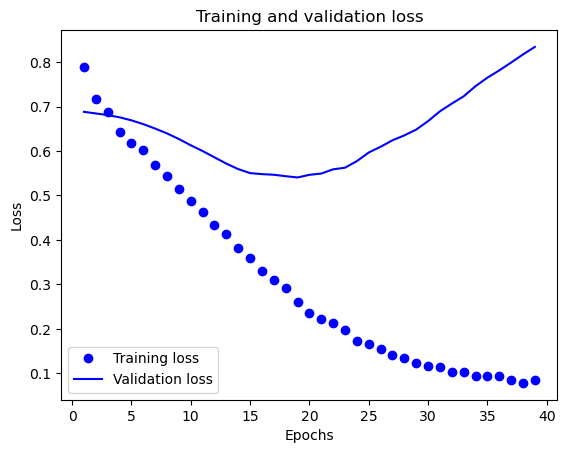

In [62]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

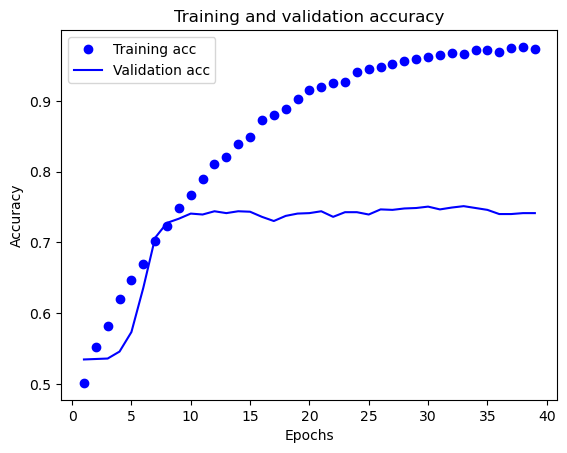

In [63]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [64]:
test_df.head()

,id,keyword,location,text,text_concat
0,0,,,Just happened a terrible car crash,just happened a terrible car crash
1,2,,,"Heard about #earthquake is different cities, s...","heard about earthquake is different cities, st..."
2,3,,,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are..."
3,9,,,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting. spokane wildfires
4,11,,,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan


In [65]:
test_examples = test_df['text_concat'].to_numpy()
test_examples[:5]

array(['just happened a terrible car crash',
       'heard about earthquake is different cities, stay safe everyone.',
       'there is a forest fire at spot pond, geese are fleeing across the street, i cannot save them all',
       'apocalypse lighting. spokane wildfires',
       'typhoon soudelor kills 28 in china and taiwan'], dtype=object)

In [66]:
results = model.predict(test_examples)
results[:5]

102/102 [==============================] - 9s 92ms/step


array([[-0.36031568],
       [ 0.06489955],
       [ 1.3689954 ],
       [ 0.51265144],
       [ 1.6914818 ]], dtype=float32)

In [67]:
threshold = 0.5
predicted_labels = np.where(results > threshold, 1, 0)

print(predicted_labels[:5])

[[0]
 [0]
 [1]
 [1]
 [1]]


In [68]:
predicted_labels_array = [x[0] for x in predicted_labels]
print(predicted_labels_array[:5])

[0, 0, 1, 1, 1]


In [69]:
result_df = test_df[['id']]
result_df = result_df.assign(target=predicted_labels_array)
result_df.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,1
4,11,1


In [70]:
result_df.reset_index(drop=True)
result_df.to_csv('/kaggle/working/out.csv', index=False)  

In [ ]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.